In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import lzma
import pandas as pd

In [2]:
model_type  = 'gru'

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)    # GRU
        self.fc = nn.Linear(hidden_size, 1)                                         # Linear

    def forward(self, x):               
        gru_out, _ = self.gru(x)                            # Pass sequence through GRU    
        last_out = gru_out[:, -1, :]                        # Take the hidden state of the last time step 
        x = self.fc(last_out)                               # Linear combination         
        x = torch.relu(x + 10) - torch.relu(x - 10) - 10    # clamp between -10 and 10
        return x

In [3]:
# Function to extract last output from the model
def extract_last_output(model, inputs):
    model.eval()
    last_outputs = []

    with torch.no_grad():
        for seq_input in inputs:
            seq_input = seq_input.unsqueeze(0).unsqueeze(-1)  # Shape: (1, seq_length, input_size)
            gru_out, _ = model.gru(seq_input)
            last_out = gru_out[:, -1, :]
            last_outputs.append(last_out.squeeze().cpu().numpy())  # Move output back to CPU for NumPy conversion

    return np.array(last_outputs)

In [4]:
def get_plot_hidden_feature_target(dataset, hidden_size, num_layers, test_fold):
    # Initialize the model (ensure the correct input size and layer sizes)
    model = GRUModel(1, hidden_size, num_layers)

    # Load the model weights
    model.load_state_dict(torch.load(f'../model/RNN/saved_models/{model_type}_{dataset}_{num_layers}layers_{hidden_size}features_fold{test_fold}.pth', map_location=torch.device('cpu')))

    # inputs and outputs
    file_path = f'../sequence_data/{dataset}/profiles.csv.xz'
    with lzma.open(file_path, 'rt') as file:
        signal_df = pd.read_csv(file)

    seqs = tuple(signal_df.groupby('sequenceID'))
    inputs = [torch.tensor(seq[1]['signal'].to_numpy(), dtype=torch.float32) for seq in seqs]

    seq_IDs = [seq[0] for seq in seqs]
    target_df = pd.read_csv(f'../training_data/{dataset}/target.csv')
    target_df = target_df[target_df['sequenceID'].isin(seq_IDs)]
    output = torch.tensor(target_df.iloc[:, 1:].to_numpy())

    # Extract last outputs for each sequence in inputs
    last_outputs = extract_last_output(model, inputs)

    # PLOT
    # Number of features to plot
    num_features = last_outputs.shape[1]

    # Calculate the number of rows needed for 2 features per row
    num_rows = (num_features + 1) // 2  # Ceiling division to determine number of rows

    # Create a single figure with subplots (2 features per row)
    fig, axs = plt.subplots(num_rows, 2, figsize=(4 * 2, 4 * num_rows), constrained_layout=True)

    # Flatten the axes array for easier indexing
    axs = axs.flatten()

    # Total number of samples
    total_samples = last_outputs.shape[0]

    # Set the number of random points to sample
    num_random_points = 600

    # Ensure we do not exceed the number of available samples
    num_random_points = min(num_random_points, total_samples)

    # Iterate through each feature and plot
    for i in range(num_features):
        # Extract feature from last_outputs
        feature = last_outputs[:, i]
        
        # Convert target outputs to NumPy arrays for plotting
        target_outputs_low = output.numpy()[:, 0]
        target_outputs_up = output.numpy()[:, 1]

        # Calculate the 25th and 75th percentiles of the feature
        q25 = np.percentile(feature, 8)
        q75 = np.percentile(feature, 92)

        # Filter the feature based on quartiles
        quartile_indices = (feature >= q25) & (feature <= q75)

        # Randomly select indices from the filtered data
        filtered_feature = feature[quartile_indices]
        filtered_target_outputs_low = target_outputs_low[quartile_indices]
        filtered_target_outputs_up = target_outputs_up[quartile_indices]

        # If there are more than 200 points in the filtered data, sample randomly
        if filtered_feature.shape[0] > num_random_points:
            random_indices = np.random.choice(filtered_feature.shape[0], size=num_random_points, replace=False)
            random_feature = filtered_feature[random_indices]
            random_target_outputs_low = filtered_target_outputs_low[random_indices]
            random_target_outputs_up = filtered_target_outputs_up[random_indices]
        else:
            random_feature = filtered_feature
            random_target_outputs_low = filtered_target_outputs_low
            random_target_outputs_up = filtered_target_outputs_up

        # Plot lower target outputs as hollow circles
        axs[i].scatter(random_feature, random_target_outputs_low, edgecolor='black', facecolor='none', label='Lower Limit', s=20, marker='o')
        
        # Plot upper target outputs as solid circles
        axs[i].scatter(random_feature, random_target_outputs_up, color='black', label='Upper Limit', s=20)

        # Adding titles and labels
        axs[i].set_title(f'Feature {i + 1} vs. Target Outputs')
        axs[i].set_xlabel(f'Feature {i + 1}')
        axs[i].set_ylabel('Target Outputs')
        axs[i].grid(True)
        axs[i].legend()

    # Hide any empty subplots
    for j in range(num_features, num_rows * 2):
        axs[j].axis('off')

    # Show the plots
    plt.show()

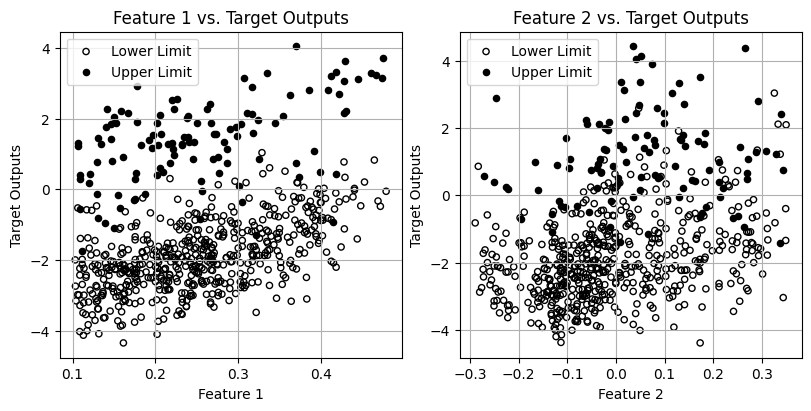

In [5]:
get_plot_hidden_feature_target('detailed', 2, 1, 1)

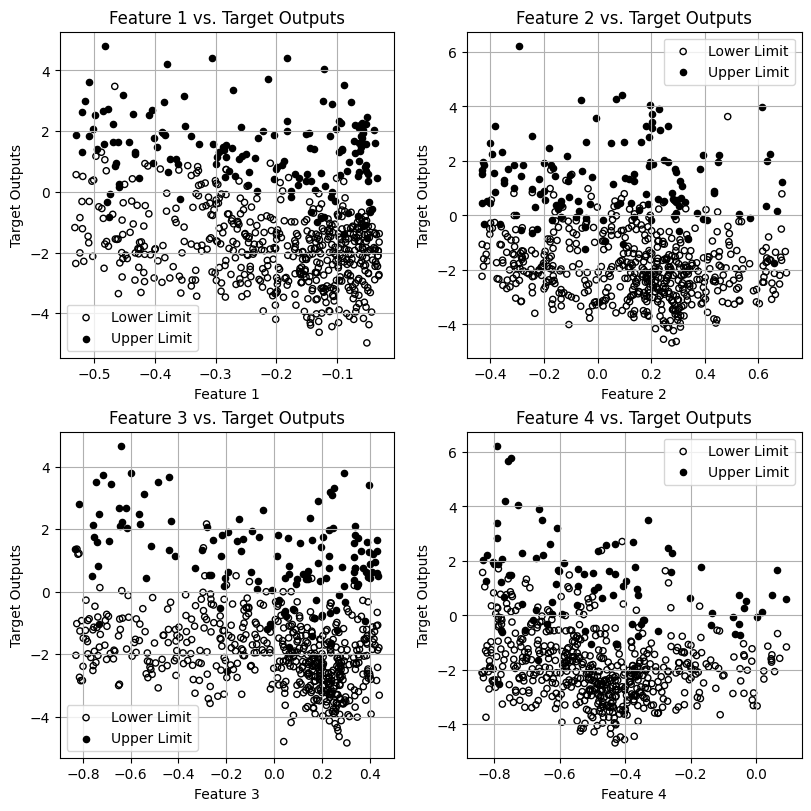

In [6]:
get_plot_hidden_feature_target('detailed', 4, 1, 6)

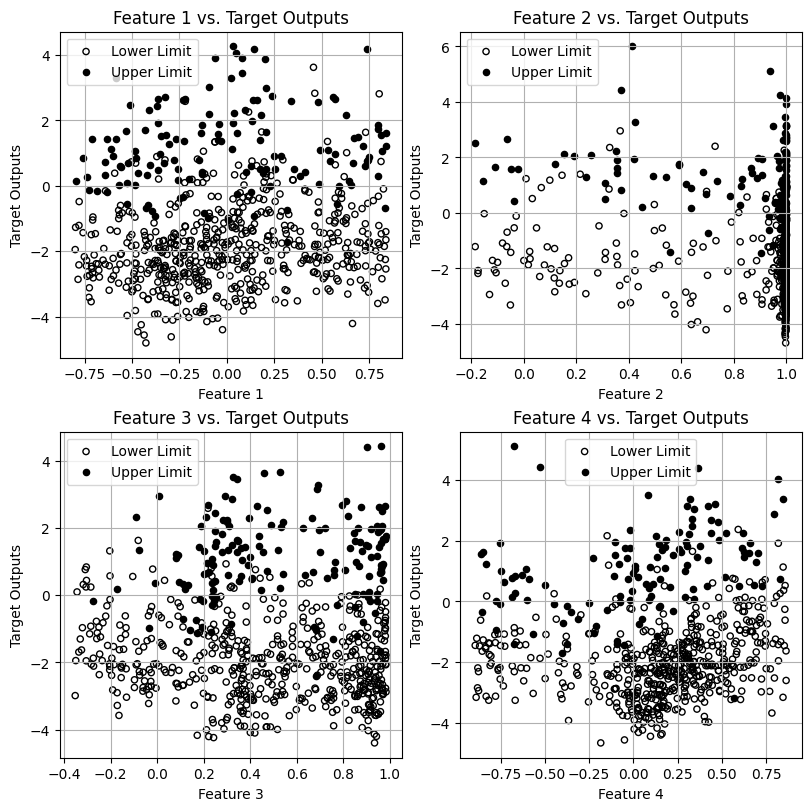

In [7]:
get_plot_hidden_feature_target('detailed', 4, 2, 1)

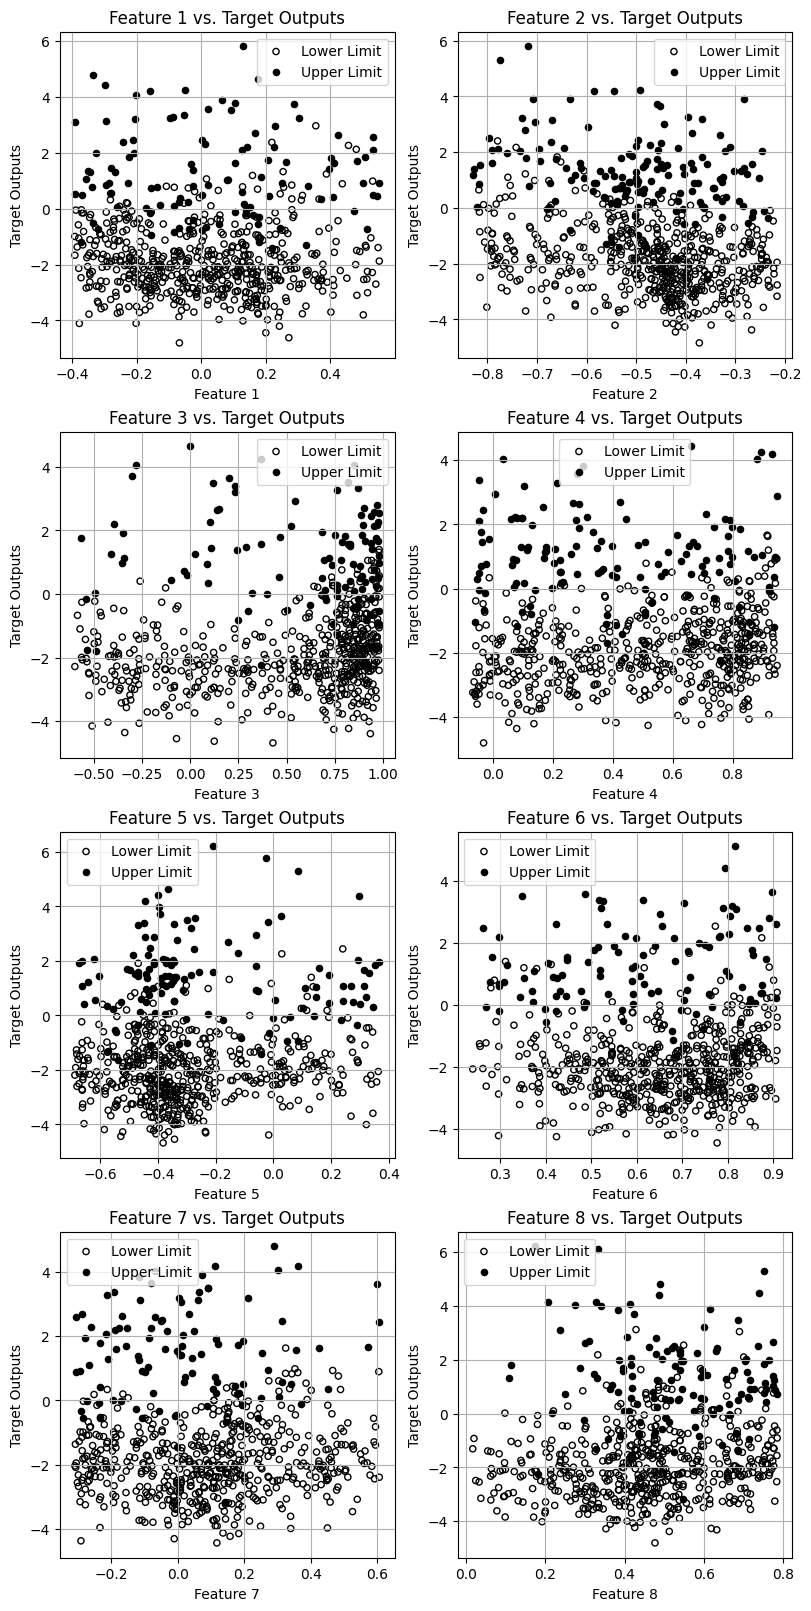

In [8]:
get_plot_hidden_feature_target('detailed', 8, 1, 1)